In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print (column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print (column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


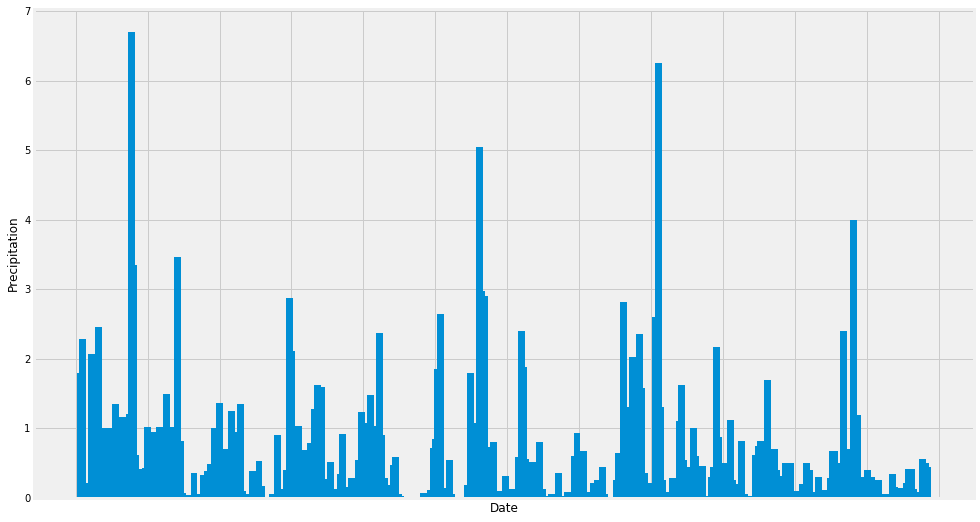

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database
latestdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# latestdate

# Perform a query to retrieve the data and precipitation scores
recentprecip = session.query(Measurement.date, Measurement.prcp).\
                    filter(func.strftime("%Y-%m-%d", Measurement.date) >= '2016-08-23').\
                    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_db = pd.DataFrame(recentprecip, columns=['Date', 'Precipitation'])
prcp_db = prcp_db.dropna()

# Sort the dataframe by date
prcp_db.set_index('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = prcp_db.index.to_list()
y_axis = prcp_db['Precipitation'].to_list()

plt.figure(figsize=(15,9))
plt.bar(x_axis, y_axis, width=3, align='center')

plt.xlabel('Date')
plt.ylabel('Precipitation')

plt.tick_params(axis='x', which='both', labelbottom=False)
plt.xticks(np.arange(-2, 375, step=31))
plt.grid(b='bool', which='major', axis='both')

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_db.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Station.station, func.count(Station.id)).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Station.station).desc()).all()

station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temps_top_station = session.query(Measurement.station, func.min(Measurement.tobs), 
                                 func.avg(Measurement.tobs))

In [17]:
# Choose the station with the highest number of temperature observations. 'USC00519281'
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station = 'USC00519281'
temps = session.query(Measurement.date, Measurement.tobs).\
            filter(Measurement.station == 'USC00519281').\
            filter(func.strftime("%Y-%m-%d", Measurement.date) >= '2016-08-23').all()

temps_df = pd.DataFrame(temps, columns= ['Date', 'Tempurature'])
temps_df = temps_df.dropna()
temps_df = temps_df.sort_values(by='Date', ascending=True)
# temps_df = temps_df.set_index('Date', inplace=True)
temps_df

,Date,Tempurature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


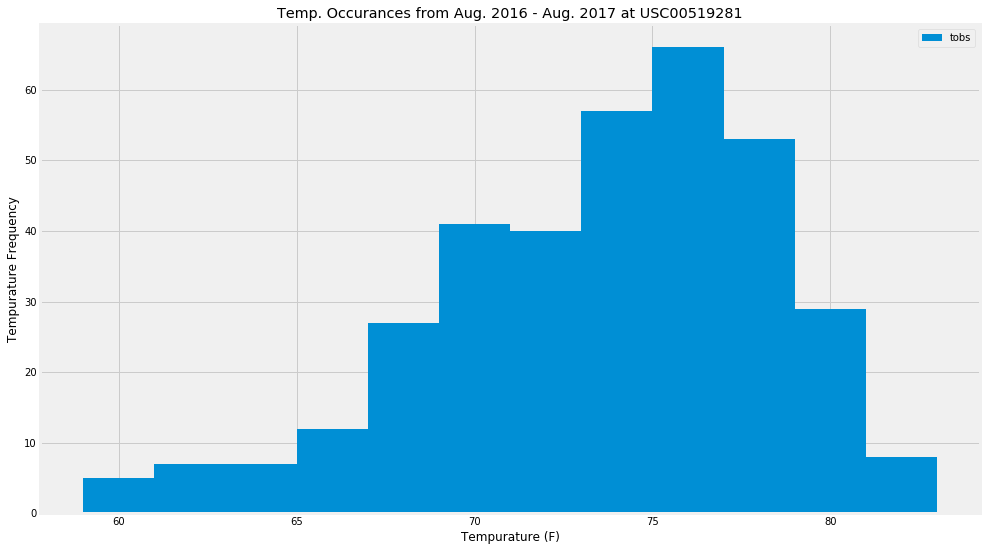

In [18]:
plt.figure(figsize=(15,9))
hist_temp = temps_df['Tempurature']
plt.hist(x=hist_temp, bins=12, label='tobs')
plt.title('Temp. Occurances from Aug. 2016 - Aug. 2017 at USC00519281')
plt.xlabel('Tempurature (F)')
plt.ylabel('Tempurature Frequency')
plt.legend()

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.date >= start_date).\
                filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-06-01'
end_date = '2017-06-07'
temp_results = calc_temps(start_date,end_date)[0]
temp_min = round(temp_results[0])
temp_avg = round(temp_results[1])
temp_max = round(temp_results[2])

print (f"""
        Min. Temp: {temp_min}
        Avg. Temp: {temp_avg}
        Max. Temp: {temp_max}
""")




        Min. Temp: 74
        Avg. Temp: 78
        Max. Temp: 81



<function matplotlib.pyplot.show(*args, **kw)>

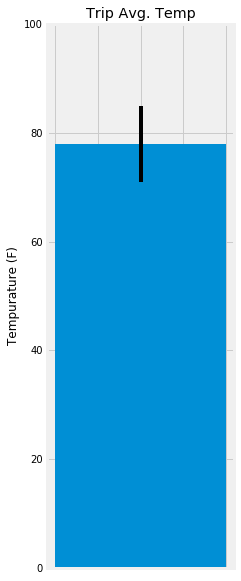

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y_err = temp_max - temp_min

x_val = 0
y_val = temp_avg

plt.figure(figsize=(3,10))
plt.bar(x_val, y_val, yerr=y_err)
plt.tick_params(axis='x', which='both', labelbottom=False)
plt.ylim(0,100)
plt.title("Trip Avg. Temp")
plt.ylabel("Tempurature (F)")
plt.show

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
query = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
query_result = session.query(*query).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= startdate).\
    filter(Measurement.date <= enddate).\
    order_by(func.sum(Measurement.prcp).desc()).\
    all()
  
stations = pd.DataFrame(query_result, columns=['Station','Name','Latitude','Longitude','Elevation','Precipitation'])
stations


,Station,Name,Latitude,Longitude,Elevation,Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.85
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.48
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.38
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.35
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.15
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.02
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
